In [1]:
import time
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from data_cleaning import data_cleaning
from data_loader import feature_extraction_dataloader

test_size = 0.15
seed = 9
num_trees = 100
scoring = "accuracy"

## Cleaning data (no need to do if no new data is added)

In [4]:
data_cleaning(moeimouto=False, self_collected=True)

[STATUS] copying pics in data_set/self-collected/007_0_violet_evergarden_official to data_set/modeling_data/violet_evergarden
[STATUS] 007_0_violet_evergarden_official copy work finished
[STATUS] copying pics in data_set/self-collected/002_0_tohsaka_rin_official to data_set/modeling_data/tohsaka_rin
[STATUS] 002_0_tohsaka_rin_official copy work finished
[STATUS] copying pics in data_set/self-collected/003_0_mato_sakura_official to data_set/modeling_data/mato_sakura
[STATUS] 003_0_mato_sakura_official copy work finished
[STATUS] copying pics in data_set/self-collected/005_0_rider_medusa_official to data_set/modeling_data/rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set/self-collected/006_0_misaka_mikoto_official to data_set/modeling_data/misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set/self-collected/004_0_illyasviel_von_einzbern_official to data_set/modeling_data/illyasviel_von

In [5]:
warnings.filterwarnings('ignore')
loader = feature_extraction_dataloader()
loader.write_data(rgb=False)

[STATUS] Characters including ['violet_evergarden', 'tohsaka_rin', 'saber_arutoria_pendoragon', 'illyasviel_von_einzbern', 'mato_sakura', 'misaka_mikoto', 'rider_medusa']
[STATUS] 1/7 processing folder: violet_evergarden
[STATUS] 2/7 processing folder: tohsaka_rin
[STATUS] 3/7 processing folder: saber_arutoria_pendoragon
[STATUS] 4/7 processing folder: illyasviel_von_einzbern
[STATUS] 5/7 processing folder: mato_sakura
[STATUS] 6/7 processing folder: misaka_mikoto
[STATUS] 7/7 processing folder: rider_medusa
[STATUS] completed Feature Extraction.
[STATUS] feature vector shape: (791, 532)
[STATUS] rgb vector shape: (0,)
[STATUS] label vector shape: (791,)
[STATUS] training labels encoded.
[STATUS] save to data_set/img_feature.mat


### load saved data

In [6]:
data = sio.loadmat(os.path.join('data_set', 'img_feature.mat'))

### normalize data

In [7]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['image_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [8]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (672, 532)
Test data    : (119, 532)
Train labels : (672,)
Test labels  : (119,)


### use cross validation to find out the performance of each model

[CROSS_VAL_SCORE] Training LR : accuracy: 0.772, std: 0.009
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training KNN : accuracy: 0.676, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training CART : accuracy: 0.632, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training RF : accuracy: 0.826, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training NB : accuracy: 0.496, std: 0.047
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training SVM : accuracy: 0.729, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s


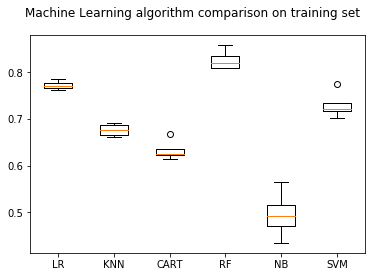

In [12]:
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.001, C=1, warm_start=True),
#           'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed)}

results = []
names = []

for name in models:
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [40]:
def plot_hypertune(params, model_names, scores):
    fig = plt.figure()
    fig.suptitle('Machine Learning algorithm comparison on training set')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(model_names)
    plt.xticks(rotation=-45)
    # plt.show()

    accuracies = [r.mean() for r in scores]
    plt.plot(params, accuracies)
    plt.show()

Logistic regression hyperparam tunning

Logistic regression penalty

In [74]:
list_p = ["l2", "none"]
list_c = np.linspace(1.5, 2.4, 10)

p_models = dict()

for i in list_p:
    p_models[i] = dict()
    for c in list_c:
        p_models[i][c] =  LogisticRegression(penalty=i, max_iter=MAX_ITER, random_state=seed,
                                             tol=TOL, C=c, warm_start=True)

p_results = {'l2': [], "none": []}
p_names = {'l2': [], "none": []}

for penalty in p_models:
    for name, model in p_models[penalty].items():
        since = time.time()
        kf = KFold(n_splits=4, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        p_results[penalty].append(cv_results)
        p_names[penalty].append(name)
        print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name,
                                                                                     cv_results.mean(),
                                                                                     cv_results.std()))
        time_elapsed = time.time() - since
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                                       time_elapsed % 60))

[CROSS_VAL_SCORE] Training 1.5 : accuracy: 0.784, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.6 : accuracy: 0.786, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.7 : accuracy: 0.786, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.8 : accuracy: 0.787, std: 0.014
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.9 : accuracy: 0.786, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.0 : accuracy: 0.784, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.1 : accuracy: 0.786, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.2 : accuracy: 0.786, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.3 : accuracy: 0.783, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.4 : accuracy: 0.780, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL

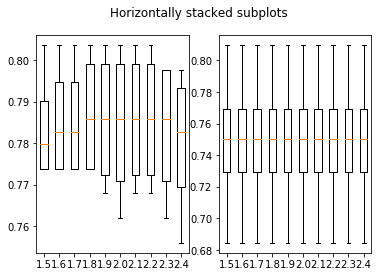

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.boxplot(p_results['l2'])
ax1.set_xticklabels(p_names['l2'])
ax2.boxplot(p_results['none'])
ax2.set_xticklabels(p_names['none'])
plt.show()

Logistic regression C

In [24]:
MAX_ITER = 10000 # tunned, no change after 100
TOL = 1e-4 # tunned, no change
C = 1.8 # tunned

In [42]:
# c_models = {i: LogisticRegression(max_iter=MAX_ITER, random_state=seed, tol=TOL, C=i, warm_start=True)
#             for i in [1.6, 1.4, 1.3, 1.2, 1.1, 1., .9, .8, .7, .6, .5, .4, .3, .2, .1]}

list_i = np.linspace(.1, 10., 100)

c_models = {i: LogisticRegression(max_iter=MAX_ITER, random_state=seed, tol=TOL, C=i, warm_start=True)
            for i in np.linspace(.1, 10, 100)}

results = []
names = []

for name in c_models:
    since = time.time()
    model = c_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
# fig = plt.figure()
# fig.suptitle('Machine Learning algorithm comparison on training set')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.xticks(rotation=-45)
# # plt.show()

# accuracies = [r.mean() for r in results]
# plt.plot(list_i, accuracies)
# plt.show()

[CROSS_VAL_SCORE] Training 0.1 : accuracy: 0.659, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.2 : accuracy: 0.711, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.30000000000000004 : accuracy: 0.732, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.4 : accuracy: 0.747, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.5 : accuracy: 0.757, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.6 : accuracy: 0.768, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.7000000000000001 : accuracy: 0.772, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.8 : accuracy: 0.772, std: 0.014
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.9 : accuracy: 0.775, std: 0.010
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.0 : accuracy: 0.772, std: 0.009
[TIME_CONSUMPTION

[CROSS_VAL_SCORE] Training 8.1 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.2 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.3 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.4 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.5 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.6 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.7 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.8 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 8.9 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 9.0 : accuracy: 0.784, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL

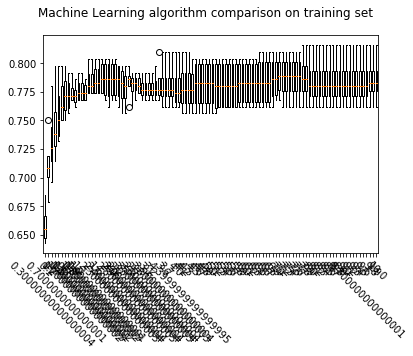

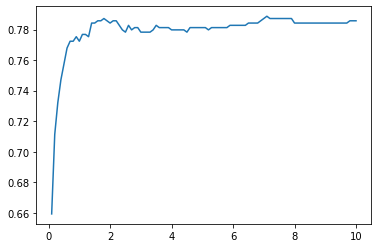

In [44]:
# plot_hypertune(list_i, names, results)
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=-45)
plt.show()

accuracies = [r.mean() for r in results]
plt.plot(list_i, accuracies)
plt.show()

KNN hyperparam tunning

In [65]:
list_i = range(1, 30)

k_models = {k: KNeighborsClassifier(n_neighbors=k) for k in list_i}

results = []
names = []

for name in k_models:
    since = time.time()
    model = k_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

[CROSS_VAL_SCORE] Training 1 : accuracy: 0.689, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 2 : accuracy: 0.647, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 3 : accuracy: 0.665, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 4 : accuracy: 0.673, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 5 : accuracy: 0.676, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 6 : accuracy: 0.679, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 7 : accuracy: 0.667, std: 0.007
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 8 : accuracy: 0.679, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 9 : accuracy: 0.664, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 10 : accuracy: 0.640, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 11

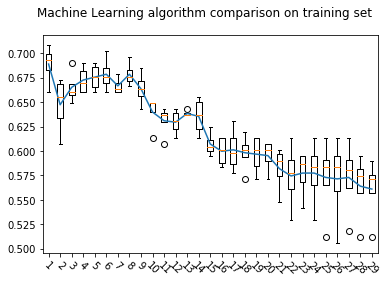

In [66]:
plot_hypertune(list_i, names, results)

SVM model hyperparam tuning

In [ ]:
list_c = range(1, 30)

svm_models = {k: SVC(random_state=seed) for k in list_i}

svm_results = []
svm_names = []

for name in svm_models:
    since = time.time()
    model = svm_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(svm_results)
    names.append(svm_name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
plot_hypertune(list_i, svm_names, svm_results)

### Train the models and see the accuracy rate on both training and testing set

In [11]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 0.386
[RESULT] LR accuracy on testing set: 0.280
[TIME_CONSUMPTION] Finishing in 0m 32s
[RESULT] LDA accuracy on training set: 0.403
[RESULT] LDA accuracy on testing set: 0.262
[TIME_CONSUMPTION] Finishing in 0m 1s
[RESULT] KNN accuracy on training set: 0.468
[RESULT] KNN accuracy on testing set: 0.224
[TIME_CONSUMPTION] Finishing in 2m 15s
[RESULT] CART accuracy on training set: 0.997
[RESULT] CART accuracy on testing set: 0.192
[TIME_CONSUMPTION] Finishing in 0m 11s
[RESULT] RF accuracy on training set: 0.997
[RESULT] RF accuracy on testing set: 0.458
[TIME_CONSUMPTION] Finishing in 0m 32s
[RESULT] NB accuracy on training set: 0.378
[RESULT] NB accuracy on testing set: 0.111
[TIME_CONSUMPTION] Finishing in 0m 16s
[RESULT] SVM accuracy on training set: 0.340
[RESULT] SVM accuracy on testing set: 0.245
[TIME_CONSUMPTION] Finishing in 3m 21s


### Best model: Random Froest
We build some examples using random forest model.

In [ ]:
best_model = models['RF']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = cv2.imread(pic_dir)
        display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic_feature = loader.extract_single_image(pic_dir)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(display_image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()

### Confusion Matrix

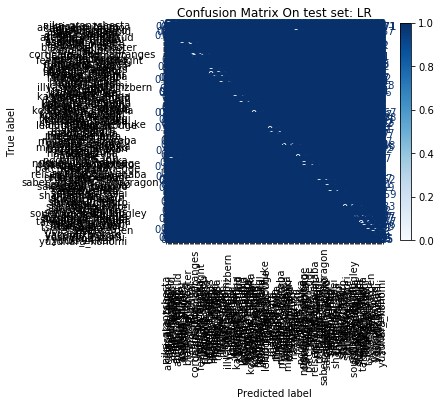

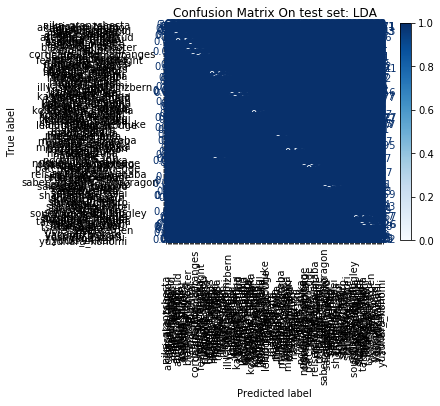

KeyboardInterrupt: 

In [12]:
for key in models.keys():
    model = models[key]
    disp = plot_confusion_matrix(model, fv_tst, fv_l_tst,
                                 display_labels=name_label_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.xticks(rotation='vertical', horizontalalignment="center")
    disp.ax_.set_title("Confusion Matrix On test set: {}".format(key))
    plt.show()